In [3]:
import os
import glob
from dotenv import load_dotenv


In [7]:
# imports for langchain and Chroma and plotly

from langchain.document_loaders import DirectoryLoader, TextLoader
from langchain.text_splitter import CharacterTextSplitter
from langchain.schema import Document
from langchain_openai import OpenAIEmbeddings, ChatOpenAI
from langchain_chroma import Chroma
import numpy as np
from sklearn.manifold import TSNE
import plotly.graph_objects as go
import openai


In [5]:
# price is a factor for our company, so we're going to use a low cost model

MODEL = "gpt-4o-mini"
db_name = "vector_db"

In [8]:
# In[14]:
# Load environment variables from the specified .env file
env_path = '/keys.env'  # Update this path if necessary
load_dotenv(env_path)

# Set the OpenAI API key
openai.api_key = os.getenv('OPENAI_API_KEY')

# Check if the API key is loaded correctly (optional for debugging)
if openai.api_key:
    print("✅ OpenAI API Key loaded successfully.")
else:
    print("❌ Error: OpenAI API Key not found. Please check your .env file.")


✅ OpenAI API Key loaded successfully.


In [12]:
# In[16]:
# Path to the specific Markdown file

#= r'/Tintinallis_Emergency_Medicine/Section 1.md'  # Update this path if necessary
input_file_path = r'/Tintinallis_Emergency_Medicine/Section 1_summaries.md'  # Output summary file

print(f"📄 Input File: {input_file_path}")
#print(f"📄 Output Summary File: {output_file_path}")

# In[17]:
#from langchain.document_loaders import TextLoader
#from langchain.text_splitter import CharacterTextSplitter

# Load the specific Markdown document using LangChain's TextLoader
loader = TextLoader(input_file_path, autodetect_encoding=True)
documents = loader.load()

print(f"✅ Loaded {len(documents)} document(s) from {input_file_path}.")

# Split the document into chunks using LangChain's CharacterTextSplitter
text_splitter = CharacterTextSplitter(chunk_size=3000, chunk_overlap=400)
chunks = text_splitter.split_documents(documents)

print(f"✅ Split document into {len(chunks)} chunks.")



📄 Input File: /Tintinallis_Emergency_Medicine/Section 1_summaries.md
✅ Loaded 1 document(s) from /Tintinallis_Emergency_Medicine/Section 1_summaries.md.
✅ Split document into 46 chunks.


In [13]:
embeddings = OpenAIEmbeddings()


In [14]:
if os.path.exists(db_name):
    Chroma(persist_directory=db_name, embedding_function=embeddings).delete_collection()

In [15]:
# Create our Chroma vectorstore!

vectorstore = Chroma.from_documents(documents=chunks, embedding=embeddings, persist_directory=db_name)
print(f"Vectorstore created with {vectorstore._collection.count()} documents")

Vectorstore created with 46 documents


In [16]:
# Get one vector and find how many dimensions it has

collection = vectorstore._collection
sample_embedding = collection.get(limit=1, include=["embeddings"])["embeddings"][0]
dimensions = len(sample_embedding)
print(f"The vectors have {dimensions:,} dimensions")

The vectors have 1,536 dimensions


In [24]:
# Prework

result = collection.get(include=['embeddings', 'documents', 'metadatas'])
vectors = np.array(result['embeddings'])
documents = result['documents']
#doc_types = [metadata['doc_type'] for metadata in result['metadatas']]
#colors = [['blue', 'green', 'red', 'orange'][['products', 'employees', 'contracts', 'company'].index(t)] for t in doc_types]

In [33]:
# Extract the doc_type from metadata
doc_types = [metadata.get('doc_type', 'Section 1: Resuscitative Problems and Techniques\
 Advanced Airway Support') for metadata in result['metadatas']]

print(f"✅ Extracted doc_types for {len(doc_types)} chunks.")
doc_types

✅ Extracted doc_types for 46 chunks.


['Section 1: Resuscitative Problems and Techniques Advanced Airway Support',
 'Section 1: Resuscitative Problems and Techniques Advanced Airway Support',
 'Section 1: Resuscitative Problems and Techniques Advanced Airway Support',
 'Section 1: Resuscitative Problems and Techniques Advanced Airway Support',
 'Section 1: Resuscitative Problems and Techniques Advanced Airway Support',
 'Section 1: Resuscitative Problems and Techniques Advanced Airway Support',
 'Section 1: Resuscitative Problems and Techniques Advanced Airway Support',
 'Section 1: Resuscitative Problems and Techniques Advanced Airway Support',
 'Section 1: Resuscitative Problems and Techniques Advanced Airway Support',
 'Section 1: Resuscitative Problems and Techniques Advanced Airway Support',
 'Section 1: Resuscitative Problems and Techniques Advanced Airway Support',
 'Section 1: Resuscitative Problems and Techniques Advanced Airway Support',
 'Section 1: Resuscitative Problems and Techniques Advanced Airway Support',

In [34]:
# In[19]:
import matplotlib.pyplot as plt
import numpy as np

# Identify unique document types
unique_doc_types = sorted(set(doc_types))
print(f"Unique doc_types found: {unique_doc_types}")

# Define a color palette
# Using a predefined color palette from matplotlib
color_palette = plt.get_cmap('tab20')  # 'tab20' has 20 distinct colors

# Create a mapping from doc_type to color
color_map = {doc_type: color_palette(i) for i, doc_type in enumerate(unique_doc_types)}

# Assign colors to each chunk based on its doc_type
colors = [color_map[doc_type] for doc_type in doc_types]

# For Plotly, colors need to be in hexadecimal or numeric format
# Convert RGBA to hexadecimal
def rgba_to_hex(rgba):
    return f'rgba({int(rgba[0]*255)}, {int(rgba[1]*255)}, {int(rgba[2]*255)}, {rgba[3]})'

colors_hex = [rgba_to_hex(color) for color in colors]


Unique doc_types found: ['Section 1: Resuscitative Problems and Techniques Advanced Airway Support']


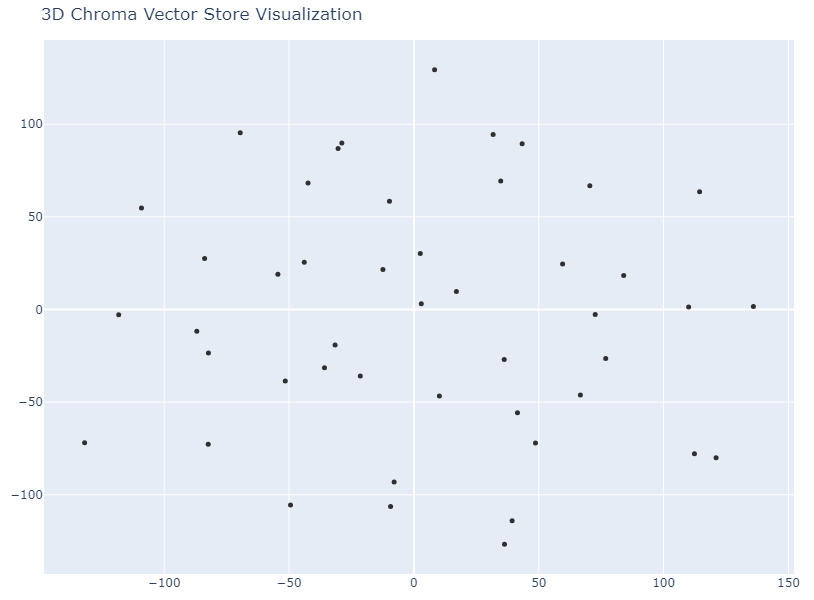

In [41]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=3, random_state=42,)
reduced_vectors = tsne.fit_transform(vectors)

# Create the 2D scatter plot
fig = go.Figure(data=[go.Scatter(
    x=reduced_vectors[:, 0],
    y=reduced_vectors[:, 1],
    mode='markers',
    marker=dict(size=5, color=colors, opacity=0.8),
    text=[f"Type: {t}<br>Text: {d[:100]}..." for t, d in zip(doc_types, documents)],
    hoverinfo='text'
)])

fig.update_layout(
    title='3D Chroma Vector Store Visualization',
    scene=dict(xaxis_title='x',yaxis_title='y'),
    width=800,
    height=600,
    margin=dict(r=20, b=10, l=10, t=40)
)

fig.show()

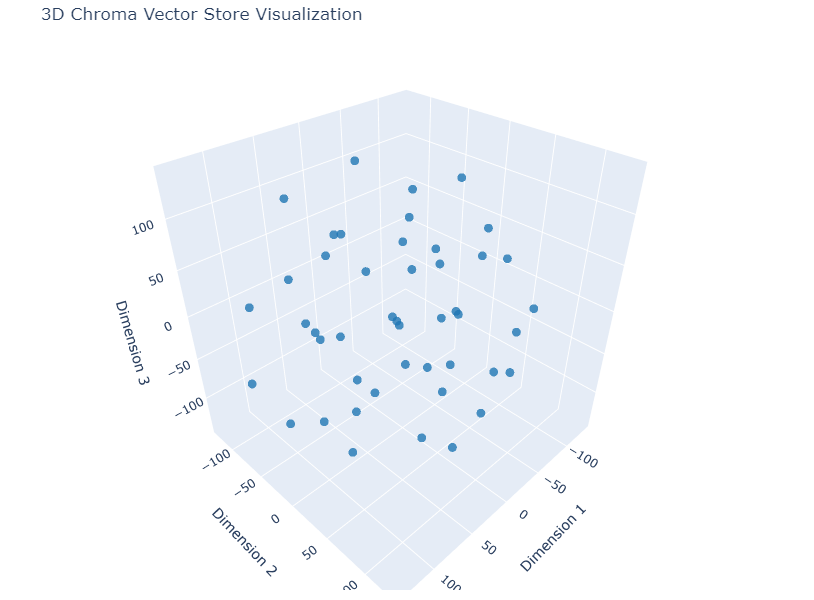

In [42]:
# In[21]:
import plotly.graph_objects as go

# Create the 3D scatter plot with colors based on doc_type
fig = go.Figure(data=[go.Scatter3d(
    x=reduced_vectors[:, 0],
    y=reduced_vectors[:, 1],
    z=reduced_vectors[:, 2],
    mode='markers',
    marker=dict(
        size=5,
        color=colors_hex,  # Use the hexadecimal colors
        opacity=0.8
    ),
    text=[f"Type: {t}<br>Text: {d[:100]}..." for t, d in zip(doc_types, documents)],
    hoverinfo='text'
)])

fig.update_layout(
    title='3D Chroma Vector Store Visualization',
    scene=dict(
        xaxis_title='Dimension 1',
        yaxis_title='Dimension 2',
        zaxis_title='Dimension 3'
    ),
    width=800,
    height=600,
    margin=dict(r=20, b=10, l=10, t=40)
)

fig.show()
